In [40]:
from modules.one_hot_module import build_df_onehot

df = build_df_onehot()

df.columns.unique()

Index(['gender', 'age', 'under_12_years_old', 'over_60_years_old',
       'patient_needs_companion', 'no_show', 'days_since_first_visit',
       'average_temp_day', 'max_temp_day', 'average_rain_day',
       ...
       'icd_s24', 'icd_s72.3', 'icd_t00', 'icd_t91.3', 'icd_z00', 'icd_z00.1',
       'icd_z11.2', 'icd_z71.2', 'icd_z89.4', 'icd_null'],
      dtype='object', length=110)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from modules.machine_module import ML_module, LGBM_module

# 로지스틱

lg = LogisticRegression()
lg = ML_module(model=lg, df=df, target_col='no_show', feature_col=None,  drop_cols=['appointment_id', 'name', 'under_12_years_old', 'over_60_years_old', 'no_show', 'icd', 'specialty_ko'], test_size=0.2, random_state=42, threshold=0.2, smote=True)
print(lg)
# print(f"로지스틱 train score : {lg['train_score']:.4f}, test score : {lg['test_score']:.4f}")

{'model': LogisticRegression(), 'feature_col': ['gender', 'age', 'patient_needs_companion', 'days_since_first_visit', 'average_temp_day', 'max_temp_day', 'average_rain_day', 'max_rain_day', 'storm_day_before', 'appointment_date_Fri', 'appointment_date_Mon', 'appointment_date_Sat', 'appointment_date_Sun', 'appointment_date_Thu', 'appointment_date_Tue', 'appointment_date_Wed', 'appointment_datetime_Jan', 'appointment_datetime_Feb', 'appointment_datetime_Mar', 'appointment_datetime_Apr', 'appointment_datetime_May', 'appointment_datetime_Jun', 'appointment_datetime_Jul', 'appointment_datetime_Aug', 'appointment_datetime_Sep', 'appointment_datetime_Oct', 'appointment_datetime_Nov', 'appointment_datetime_Dec', 'disability_intellectual', 'disability_motor', 'disability_null', 'specialty_physiotherapy', 'specialty_psychotherapy', 'specialty_speech therapy', 'specialty_occupational therapy', 'specialty_unknown', 'specialty_enf', 'specialty_assist', 'specialty_pedagogo', 'specialty_sem especiali

In [13]:
gbm = LGBM_module(df, 'no_show', None, drop_cols=['appointment_id', 'name', 'under_12_years_old', 'over_60_years_old', 'no_show', 'icd', 'specialty_ko'], task='classifier' , lgbm_params={"n_estimators":300, "learning_rate":0.2}, threshold=0.3, random_state=42, smote=True)
print(gbm)

[LightGBM] [Info] Number of positive: 35747, number of negative: 35747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 71494, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
{'model': LGBMClassifier(learning_rate=0.2, n_estimators=300, random_state=42), 'feature_col': ['gender', 'age', 'patient_needs_companion', 'days_since_first_visit', 'average_temp_day', 'max_temp_day', 'average_rain_day', 'max_rain_day', 'storm_day_before', 'appointment_date_Fri', 'appointment_date_Mon', 'appointment_date_Sat', 'appointment_date_Sun', 'appointment_date_Thu', 'appointment_date_Tue', 'appointment_date_Wed', 'appointment_datetime_Jan', 'appointment_datetime_Feb', 'appointment_da

[LightGBM] [Info] Number of positive: 35802, number of negative: 35802
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 71604, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                model       AUC  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.607203  0.871446   0.133017  0.057971  0.080750
1            LightGBM  0.728780  0.887477   0.312500  0.129400  0.183016


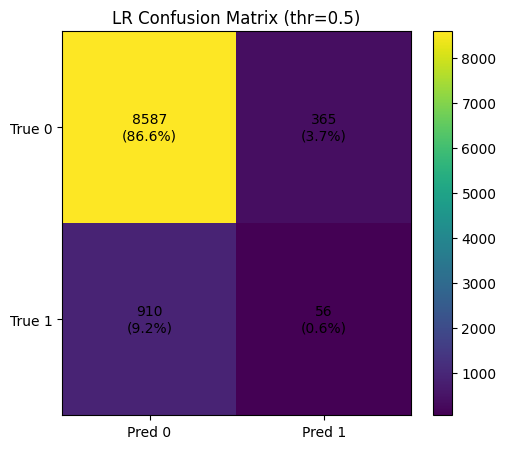

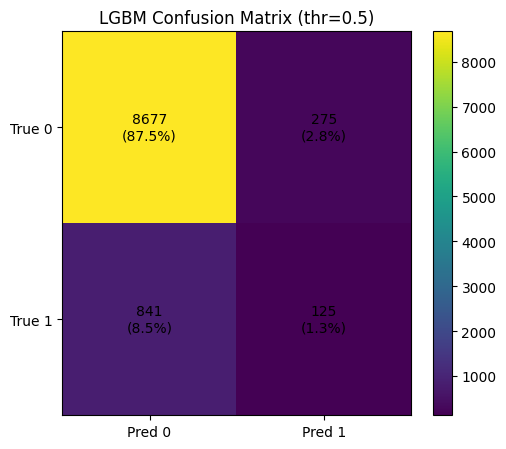

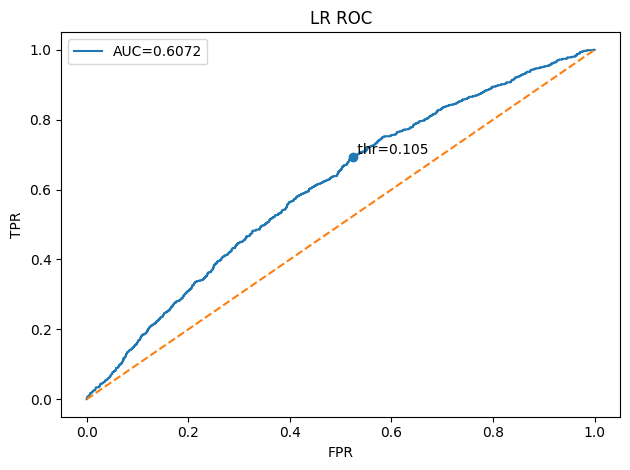

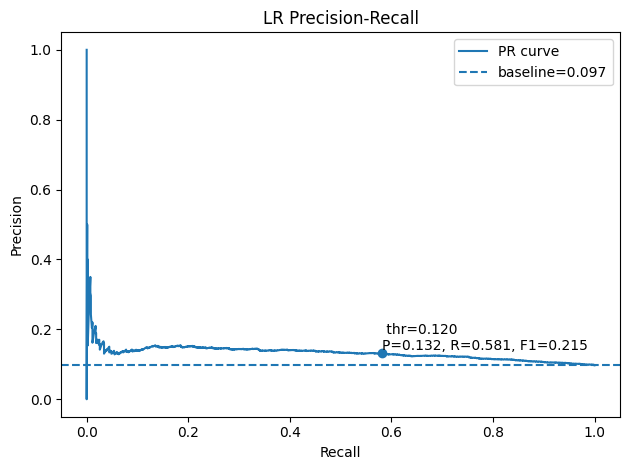

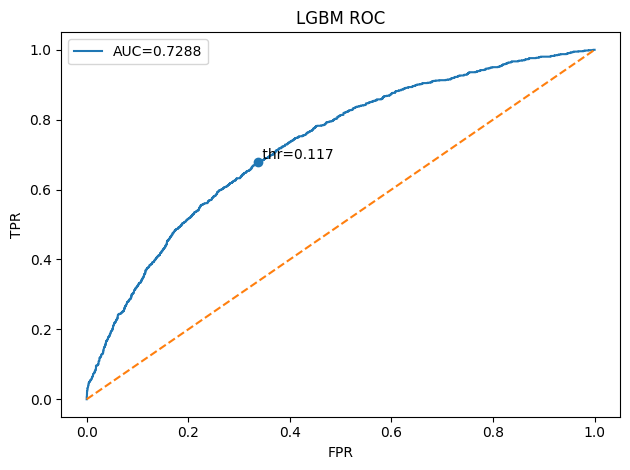

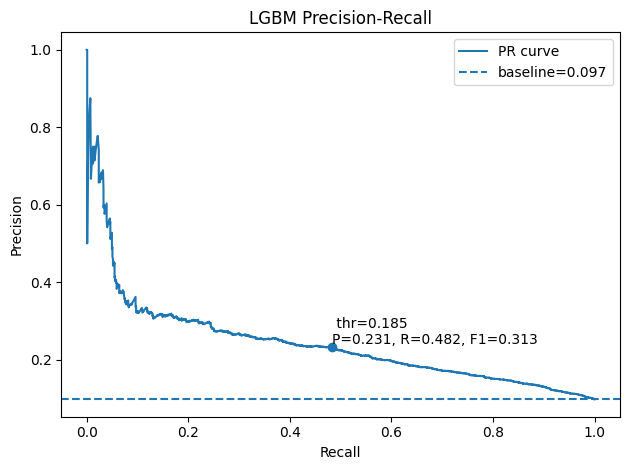

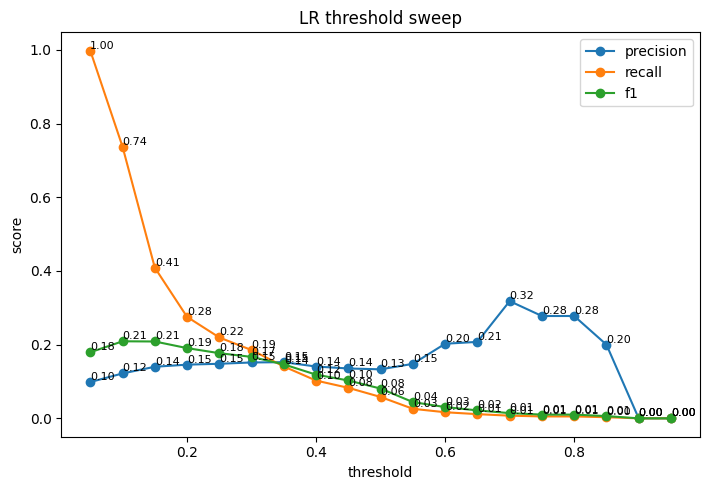

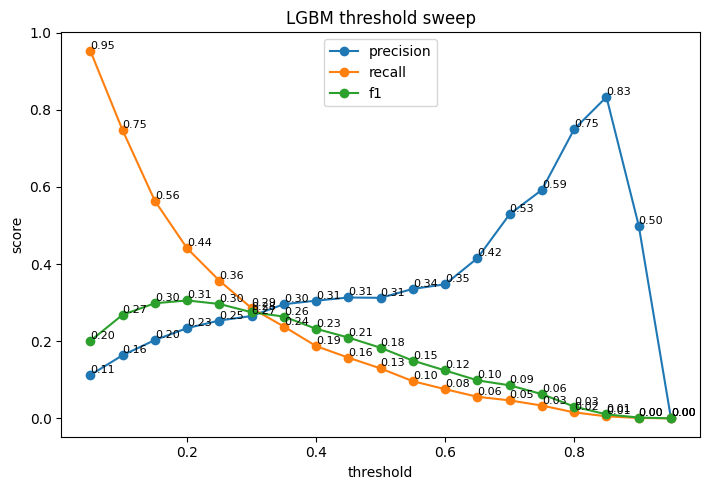

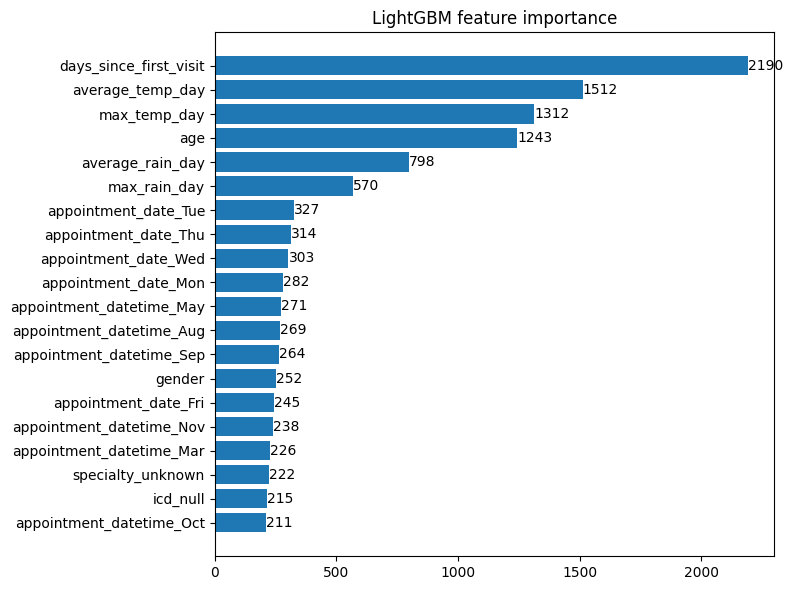

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
)
from imblearn.over_sampling import SMOTE

df = df


def sanitize_columns(df):
    df = df.copy()
    new_cols = []
    seen = {}
    for c in df.columns:
        c2 = str(c).strip()
        c2 = re.sub(r'[^0-9a-zA-Z_]+', '_', c2)   # 영문/숫자/_ 외는 _
        c2 = re.sub(r'_{2,}', '_', c2).strip('_') # __ -> _
        if c2 == "":
            c2 = "col"

        # 중복 처리
        if c2 in seen:
            seen[c2] += 1
            c2 = f"{c2}_{seen[c2]}"
        else:
            seen[c2] = 0

        new_cols.append(c2)

    df.columns = new_cols
    return df

df = sanitize_columns(df)


# ----------------------------
# 0) feature 컬럼 결정 + datetime 제거(필수)
# ----------------------------
def resolve_feature_cols(df, target_col, feature_col=None, drop_cols=None):
    drop_cols = drop_cols or []

    if feature_col is None:
        feature_col = [c for c in df.columns if c != target_col and c not in drop_cols]

    # datetime 컬럼 제거 (Timestamp -> float 에러 방지)
    dt_cols = df[feature_col].select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
    feature_col = [c for c in feature_col if c not in dt_cols]

    missing = [c for c in feature_col if c not in df.columns]
    if missing:
        raise ValueError(f"missing feature cols: {missing}")

    return feature_col


# ----------------------------
# 1) split/fit/predict_proba (시각화용)
# ----------------------------
def fit_for_viz(
    model,
    df,
    target_col="no_show",
    feature_col=None,
    drop_cols=None,
    test_size=0.2,
    random_state=42,
    stratify=True,
    threshold=0.5,
    fillna_zero=False,

    smote=False,
    smote_k_neighbors=5,
):
    feature_col = resolve_feature_cols(df, target_col, feature_col, drop_cols)

    X = df[feature_col].copy()
    y = df[target_col].to_numpy()

    # 숫자화/결측 처리 (SMOTE 쓰면 NaN 있으면 안 되므로 0 처리 권장)
    if fillna_zero or smote:
        X = X.replace(r"^\s*$", np.nan, regex=True)
        X = X.apply(pd.to_numeric, errors="coerce")
        X = X.fillna(0)

    stratify_y = y if stratify else None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_y
    )

    # SMOTE는 train에만 적용
    if smote:
        # minority count가 너무 적으면 SMOTE 실패하므로 가드
        y_train_int = pd.Series(y_train).astype(int)
        pos = int((y_train_int == 1).sum())
        neg = int((y_train_int == 0).sum())
        minority = min(pos, neg)

        if minority >= 2:
            k = min(smote_k_neighbors, minority - 1)
            sm = SMOTE(random_state=random_state, k_neighbors=k)
            X_train, y_train = sm.fit_resample(X_train, y_train)

    m = clone(model)
    m.fit(X_train, y_train)

    p_test = m.predict_proba(X_test)[:, 1]
    y_pred = (p_test >= threshold).astype(int)

    return {
        "model": m,
        "feature_col": feature_col,
        "y_test": y_test,
        "p_test": p_test,
        "cm": confusion_matrix(y_test, y_pred),
        "metrics": {
            "AUC": roc_auc_score(y_test, p_test),
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1": f1_score(y_test, y_pred, zero_division=0),
        }
    }



# ----------------------------
# 2) 그래프 함수들(필수만)
# ----------------------------
def plot_confusion(cm, title):
    cm = np.asarray(cm)
    total = cm.sum()
    pct = (cm / total) * 100

    plt.figure(figsize=(5.2, 4.6))
    plt.imshow(cm, aspect="auto")
    plt.xticks([0, 1], ["Pred 0", "Pred 1"])
    plt.yticks([0, 1], ["True 0", "True 1"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{cm[i, j]}\n({pct[i, j]:.1f}%)", ha="center", va="center")

    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


def plot_roc(y_test, p_test, title):
    fpr, tpr, thr = roc_curve(y_test, p_test)
    auc = roc_auc_score(y_test, p_test)

    # Youden J 최대
    j = tpr - fpr
    k = int(np.argmax(j))
    best_thr = thr[k]

    plt.figure(figsize=(6.4, 4.8))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.scatter([fpr[k]], [tpr[k]])
    plt.text(fpr[k], tpr[k], f" thr={best_thr:.3f}", va="bottom")

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_pr(y_test, p_test, title):
    prec, rec, thr = precision_recall_curve(y_test, p_test)
    base = np.mean(y_test)

    # thr 길이 = len(prec)-1
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    k = int(np.argmax(f1))
    best_thr = thr[k]
    best_p, best_r, best_f1 = prec[k], rec[k], f1[k]

    plt.figure(figsize=(6.4, 4.8))
    plt.plot(rec, prec, label="PR curve")
    plt.axhline(base, linestyle="--", label=f"baseline={base:.3f}")

    plt.scatter([best_r], [best_p])
    plt.text(best_r, best_p, f" thr={best_thr:.3f}\nP={best_p:.3f}, R={best_r:.3f}, F1={best_f1:.3f}", va="bottom")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_threshold_sweep(y_test, p_test, title, thresholds=None, annotate_every=1):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)

    rows = []
    for thr in thresholds:
        y_pred = (p_test >= thr).astype(int)
        p = precision_score(y_test, y_pred, zero_division=0)
        r = recall_score(y_test, y_pred, zero_division=0)
        f = f1_score(y_test, y_pred, zero_division=0)
        rows.append({"threshold": thr, "precision": p, "recall": r, "f1": f})

    df_t = pd.DataFrame(rows)

    plt.figure(figsize=(7.2, 5.0))
    plt.plot(df_t["threshold"], df_t["precision"], marker="o", label="precision")
    plt.plot(df_t["threshold"], df_t["recall"], marker="o", label="recall")
    plt.plot(df_t["threshold"], df_t["f1"], marker="o", label="f1")

    # 점 위에 숫자 찍기(너무 빽빽하면 annotate_every=2 같은 식으로)
    for i, row in df_t.iterrows():
        if i % annotate_every != 0:
            continue
        x = row["threshold"]
        plt.text(x, row["precision"], f"{row['precision']:.2f}", fontsize=8, va="bottom")
        plt.text(x, row["recall"], f"{row['recall']:.2f}", fontsize=8, va="bottom")
        plt.text(x, row["f1"], f"{row['f1']:.2f}", fontsize=8, va="bottom")

    plt.xlabel("threshold")
    plt.ylabel("score")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_t


def plot_lgbm_importance(fitted_lgbm, feature_names, topk=20, title="LightGBM feature importance"):
    imp = fitted_lgbm.feature_importances_
    s = pd.Series(imp, index=feature_names).sort_values(ascending=False).head(topk)[::-1]

    plt.figure(figsize=(8, 6))
    bars = plt.barh(s.index, s.values)
    plt.title(title)

    for b in bars:
        w = b.get_width()
        plt.text(w, b.get_y() + b.get_height()/2, f"{int(w)}", va="center")

    plt.tight_layout()
    plt.show()



# ----------------------------
# 3) 모델 정의(최소)
# ----------------------------
lr_model = LogisticRegression(max_iter=2000, class_weight="balanced")
lgbm_model = LGBMClassifier(random_state=42, n_estimators=500, learning_rate=0.05)


# ----------------------------
# 4) 실행
# ----------------------------
drop_cols = ["appointment_id", "name"]  # 필요 시 추가
THR = 0.5

# LogisticRegression: 결측치를 0으로 채우고 학습
lr_out = fit_for_viz(
    model=lr_model,
    df=df,
    target_col="no_show",
    drop_cols=drop_cols,
    stratify=True,
    threshold=THR,
    fillna_zero=True,
    smote=True,
    smote_k_neighbors=5,
)


# LightGBM: 결측치 그대로 둬도 됨(원하면 동일하게 0 채워도 됨)
lgbm_out = fit_for_viz(
    model=lgbm_model,
    df=df,
    target_col="no_show",
    drop_cols=drop_cols,
    stratify=True,
    threshold=THR,
    fillna_zero=False,   # smote=True면 내부에서 자동으로 0 채우게 처리됨
    smote=True,
    smote_k_neighbors=5,
)

summary = pd.DataFrame([
    {"model": "LogisticRegression", **lr_out["metrics"]},
    {"model": "LightGBM", **lgbm_out["metrics"]},
])
print(summary)

plot_confusion(lr_out["cm"], f"LR Confusion Matrix (thr={THR})")
plot_confusion(lgbm_out["cm"], f"LGBM Confusion Matrix (thr={THR})")

plot_roc(lr_out["y_test"], lr_out["p_test"], "LR ROC")
plot_pr(lr_out["y_test"], lr_out["p_test"], "LR Precision-Recall")

plot_roc(lgbm_out["y_test"], lgbm_out["p_test"], "LGBM ROC")
plot_pr(lgbm_out["y_test"], lgbm_out["p_test"], "LGBM Precision-Recall")

plot_threshold_sweep(lr_out["y_test"], lr_out["p_test"], "LR threshold sweep")
plot_threshold_sweep(lgbm_out["y_test"], lgbm_out["p_test"], "LGBM threshold sweep")

plot_lgbm_importance(lgbm_out["model"], lgbm_out["feature_col"], topk=20)


In [16]:
import os, json, joblib

os.makedirs("artifacts", exist_ok=True)

# ML_module 결과가 dict라고 가정 (당신이 출력한 형태 기준)
# lg["model"]  : 학습된 estimator
# lg["feature_col"] : 학습에 사용된 피처 컬럼 리스트
# lg에 scaler가 없다면 scaler 저장은 생략(= None)

trained_lg = lg["model"] if isinstance(lg, dict) else lg
feature_cols_lg = lg["feature_col"] if isinstance(lg, dict) else df.drop(
    columns=['appointment_id','name','under_12_years_old','over_60_years_old','no_show','icd','specialty_ko']
).columns.tolist()

joblib.dump(trained_lg, "artifacts/lg_model.joblib")
with open("artifacts/lg_feature_columns.json", "w", encoding="utf-8") as f:
    json.dump(feature_cols_lg, f, ensure_ascii=False)

# 만약 ML_module 안에서 scaler를 만들었다면(키 이름은 프로젝트에 맞게)
# 예: scaler = lg.get("scaler")
# if scaler is not None:
#     joblib.dump(scaler, "artifacts/lg_scaler.joblib")


trained_gbm = gbm["model"] if isinstance(gbm, dict) else gbm
feature_cols_gbm = gbm["feature_col"] if isinstance(gbm, dict) else feature_cols_lg  # 없으면 동일 drop 기준으로 직접 구해도 됨

joblib.dump(trained_gbm, "artifacts/lgbm_model.joblib")
with open("artifacts/lgbm_feature_columns.json", "w", encoding="utf-8") as f:
    json.dump(feature_cols_gbm, f, ensure_ascii=False)


In [23]:
import json, joblib
import pandas as pd
import numpy as np
import re
from modules.one_hot_module import fetch_df

def sanitize_cols(cols):
    new_cols, seen = [], {}
    for c in cols:
        c2 = str(c)
        c2 = re.sub(r"[\x00-\x1f\x7f]", "_", c2)
        c2 = re.sub(r"\s+", "_", c2)
        c2 = re.sub(r"""["'\\{}\[\]:,]""", "_", c2)
        c2 = re.sub(r"_+", "_", c2).strip("_") or "col"
        if c2 in seen:
            seen[c2] += 1
            c2 = f"{c2}_{seen[c2]}"
        else:
            seen[c2] = 0
        new_cols.append(c2)
    return new_cols

def align_features(df, feature_cols):
    X = df.copy()
    for c in feature_cols:
        if c not in X.columns:
            X[c] = 0
    return X[feature_cols]

rows = fetch_df("appointment")
df_onehot = build_df_onehot()

# LGBM 예측(컬럼 sanitize 필요)
model = joblib.load("artifacts/lgbm_model.joblib")
with open("artifacts/lgbm_feature_columns.json", "r", encoding="utf-8") as f:
    feature_cols = json.load(f)

df_onehot_s = df_onehot.copy()
df_onehot_s.columns = sanitize_cols(df_onehot_s.columns)

X = align_features(df_onehot_s, feature_cols)
proba = model.predict_proba(X)[:, 1]

rows["no_show_prob"] = proba
rows.head()


,appointment_id,appointment_datetime,appointment_date,name,specialty,gender,age,under_12_years_old,over_60_years_old,patient_needs_companion,disability,no_show,icd,entry_service_date,no_show_prob
0,248646,2021-09-09 13:20:00,2021-09-09,강은경,physiotherapy,0,11,0,0,0,,1,,None,0.454129
1,248647,2021-09-09 13:20:00,2021-09-09,김진호,psychotherapy,0,11,0,0,0,,0,,None,0.277081
2,248648,2021-09-09 13:20:00,2021-09-09,김우진,speech therapy,1,11,0,0,0,,0,,None,0.274490
3,248649,2021-09-09 13:20:00,2021-09-09,김광수,physiotherapy,1,11,0,0,0,,0,,None,0.461285
4,248650,2021-09-09 14:00:00,2021-09-09,오성호,physiotherapy,0,68,0,1,1,motor,0,i67,2020-02-05,0.060784


In [24]:
rows = fetch_df("appointment")
df_onehot = build_df_onehot()


model = joblib.load("artifacts/lg_model.joblib")
with open("artifacts/lg_feature_columns.json", "r", encoding="utf-8") as f:
    feature_cols = json.load(f)

df_onehot_s = df_onehot.copy()
df_onehot_s.columns = sanitize_cols(df_onehot_s.columns)

X = align_features(df_onehot_s, feature_cols)
proba = model.predict_proba(X)[:, 1]

rows["no_show_prob"] = proba
rows.head()


,appointment_id,appointment_datetime,appointment_date,name,specialty,gender,age,under_12_years_old,over_60_years_old,patient_needs_companion,disability,no_show,icd,entry_service_date,no_show_prob
0,248646,2021-09-09 13:20:00,2021-09-09,강은경,physiotherapy,0,11,0,0,0,,1,,None,0.479299
1,248647,2021-09-09 13:20:00,2021-09-09,김진호,psychotherapy,0,11,0,0,0,,0,,None,0.414520
2,248648,2021-09-09 13:20:00,2021-09-09,김우진,speech therapy,1,11,0,0,0,,0,,None,0.762372
3,248649,2021-09-09 13:20:00,2021-09-09,김광수,physiotherapy,1,11,0,0,0,,0,,None,0.197353
4,248650,2021-09-09 14:00:00,2021-09-09,오성호,physiotherapy,0,68,0,1,1,motor,0,i67,2020-02-05,0.489138


In [30]:
# 2) 완전히 새로운 데이터(예: 1건)
new_raw = pd.DataFrame([{
    "appointment_id": 999999,                   # 없으면 임의로 만들어도 됨
    "appointment_datetime": "2026-01-14 10:30:00",
    "appointment_date": "2026-01-14",
    "name": "신규환자",
    "specialty": "physiotherapy",
    "gender": 0,
    "age": 33,
    "under_12_years_old": 0,
    "over_60_years_old": 0,
    "patient_needs_companion": 0,
    "disability": "",
    "icd": "",
    "entry_service_date": None,
}])

In [31]:
import pandas as pd

from modules.one_hot_module import build_df_onehot

def build_df_onehot_from_input(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = raw_df.copy()

    # 아래 호출 순서는 "학습 때 build_df_onehot() 내부에서 했던 순서"와 동일해야 함
    df = build_df_onehot(df)

    # 학습 때 추가로 했던 원핫/가공이 있으면 동일하게 여기에 계속 추가
    return df

In [ ]:
import json, joblib, re
import pandas as pd

# --- 학습 때 사용한 sanitize 규칙과 동일하게 ---
def sanitize_one(name: str) -> str:
    s = str(name)
    s = re.sub(r"[\x00-\x1f\x7f]", "_", s)
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"""["'\\{}\[\]:,]""", "_", s)
    s = re.sub(r"_+", "_", s).strip("_") or "col"
    return s

MONTH_ABBR = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def predict_no_show_prob_new_raw(new_raw: pd.DataFrame,
                                 model_path="artifacts/lgbm_model.joblib",
                                 feature_cols_path="artifacts/lgbm_feature_columns.json") -> pd.DataFrame:
    model = joblib.load(model_path)
    with open(feature_cols_path, "r", encoding="utf-8") as f:
        feature_cols = json.load(f)

    # 1) 스키마(학습 피처) 기준으로 0으로 채운 X 생성
    X = pd.DataFrame(0, index=new_raw.index, columns=feature_cols, dtype=float)

    # 2) new_raw에 있는 숫자형 컬럼 중, 학습 피처에 그대로 존재하면 값 주입
    for col in ["gender", "age", "patient_needs_companion"]:
        if col in new_raw.columns and col in X.columns:
            X[col] = pd.to_numeric(new_raw[col], errors="coerce").fillna(0)

    # 3) 날짜 기반 원핫: appointment_date -> 요일
    if "appointment_date" in new_raw.columns:
        d = pd.to_datetime(new_raw["appointment_date"], errors="coerce")
        w = d.dt.strftime("%a")  # Mon/Tue/...
        for i, wd in enumerate(w):
            if pd.isna(wd):
                continue
            c = f"appointment_date_{wd}"
            if c in X.columns:
                X.iat[i, X.columns.get_loc(c)] = 1

    # 4) appointment_datetime -> 월
    if "appointment_datetime" in new_raw.columns:
        dt = pd.to_datetime(new_raw["appointment_datetime"], errors="coerce")
        m = dt.dt.month
        for i, mm in enumerate(m):
            if pd.isna(mm):
                continue
            abbr = MONTH_ABBR[int(mm) - 1]
            c = f"appointment_datetime_{abbr}"
            if c in X.columns:
                X.iat[i, X.columns.get_loc(c)] = 1

    # 5) specialty 원핫 (학습 컬럼명이 specialty_<값> 형태였다는 가정)
    if "specialty" in new_raw.columns:
        for i, v in enumerate(new_raw["specialty"].fillna("").astype(str)):
            if not v:
                # fallback
                if "specialty_unknown" in X.columns:
                    X.iat[i, X.columns.get_loc("specialty_unknown")] = 1
                continue
            c = sanitize_one(f"specialty_{v}")
            if c in X.columns:
                X.iat[i, X.columns.get_loc(c)] = 1
            elif "specialty_unknown" in X.columns:
                X.iat[i, X.columns.get_loc("specialty_unknown")] = 1

    # 6) disability 원핫 (예: disability_intellectual, disability_motor ...)
    if "disability" in new_raw.columns:
        for i, v in enumerate(new_raw["disability"].fillna("").astype(str)):
            v = v.strip()
            if not v:
                continue
            # 여러 값 가능성 대비 (쉼표/세미콜론/파이프 분리)
            parts = [p.strip() for p in re.split(r"[,\|;/]+", v) if p.strip()]
            for p in parts:
                c = sanitize_one(f"disability_{p}")
                if c in X.columns:
                    X.iat[i, X.columns.get_loc(c)] = 1

    # 7) 예측
    proba = model.predict_proba(X)[:, 1]

    out = new_raw.copy()
    out["no_show_prob"] = proba
    return out

# ---- 사용 예시 ----
new_raw = pd.DataFrame([{
    "appointment_id": 999999,
    "appointment_datetime": "2026-01-14 10:30:00",
    "appointment_date": "2026-01-14",
    "name": "신규환자",
    "specialty": "physiotherapy",
    "gender": 0,
    "age": 45,
    "patient_needs_companion": 0,
    "disability": "",
    'storm_day_before' : 1,
    "icd": "F71",
    "entry_service_date": None,
}])

result = predict_no_show_prob_new_raw(new_raw)
result


,appointment_id,appointment_datetime,appointment_date,name,specialty,gender,age,patient_needs_companion,disability,icd,entry_service_date,no_show_prob
0,999999,2026-01-14 10:30:00,2026-01-14,신규환자,physiotherapy,0,45,0,,F71,None,0.463483
